In [1]:
# Reload other .py files without having to restart the kernel
%load_ext autoreload
%autoreload 2

In [1]:
import kagglehub, pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# Make sure API token is stored in .kaggle/kaggle.json
# Download latest version
MAIN_PATH = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")
print("Path to dataset files:", MAIN_PATH)

Path to dataset files: C:\Users\Nicholas\.cache\kagglehub\datasets\rhammell\ships-in-satellite-imagery\versions\9


In [57]:
df = pd.read_json(os.path.join(MAIN_PATH, 'shipsnet.json'))
df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [ ]:
# According to the kaggle page, each sample is stored in a (80*80*3,) array where the first 6400
# values are the red channel of the image stored in row-major order, so the first 80 values are the 
# top row of the red channel. Could just load this from the image itself but I'm feeling goofy
# so we're gonna do it the stupid way.

# Convert the data to an array and get a Series as output
numpySeries = df['data'].apply(np.array) # similar to map(func, iterable)
print(numpySeries.shape)

# Stack all the data along axis 0. Remember that axis 0 is actually the vertical direction
arr = np.stack(numpySeries, axis=0)
print(arr.shape)

# Reshape in Fortran order where the first index changes fastest. 
# We will read 80 reds of the first row
# We will then read 80 of those red columns meaning we traversed 6400 values total
# Finally, we will go to the next axis index to start the green channel.
images = np.reshape(arr, (-1, 80, 80, 3), order='F')
print(images.shape)

(4000,)
(4000, 19200)
(4000, 80, 80, 3)


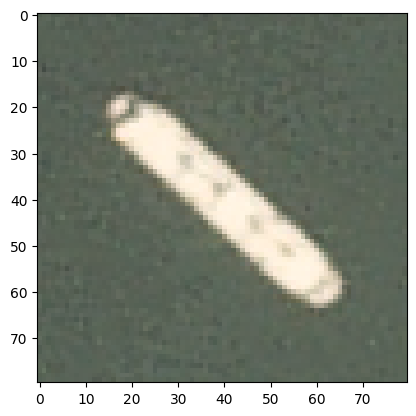

In [61]:
# Didn't realize this at the time, but we can just reshape each element in place
df['data'] = df['data'].apply(lambda x: np.reshape(np.array(x), (80, 80, 3), order='F'))
df['data'][0].shape
plt.imshow(df['data'][0])
plt.show()

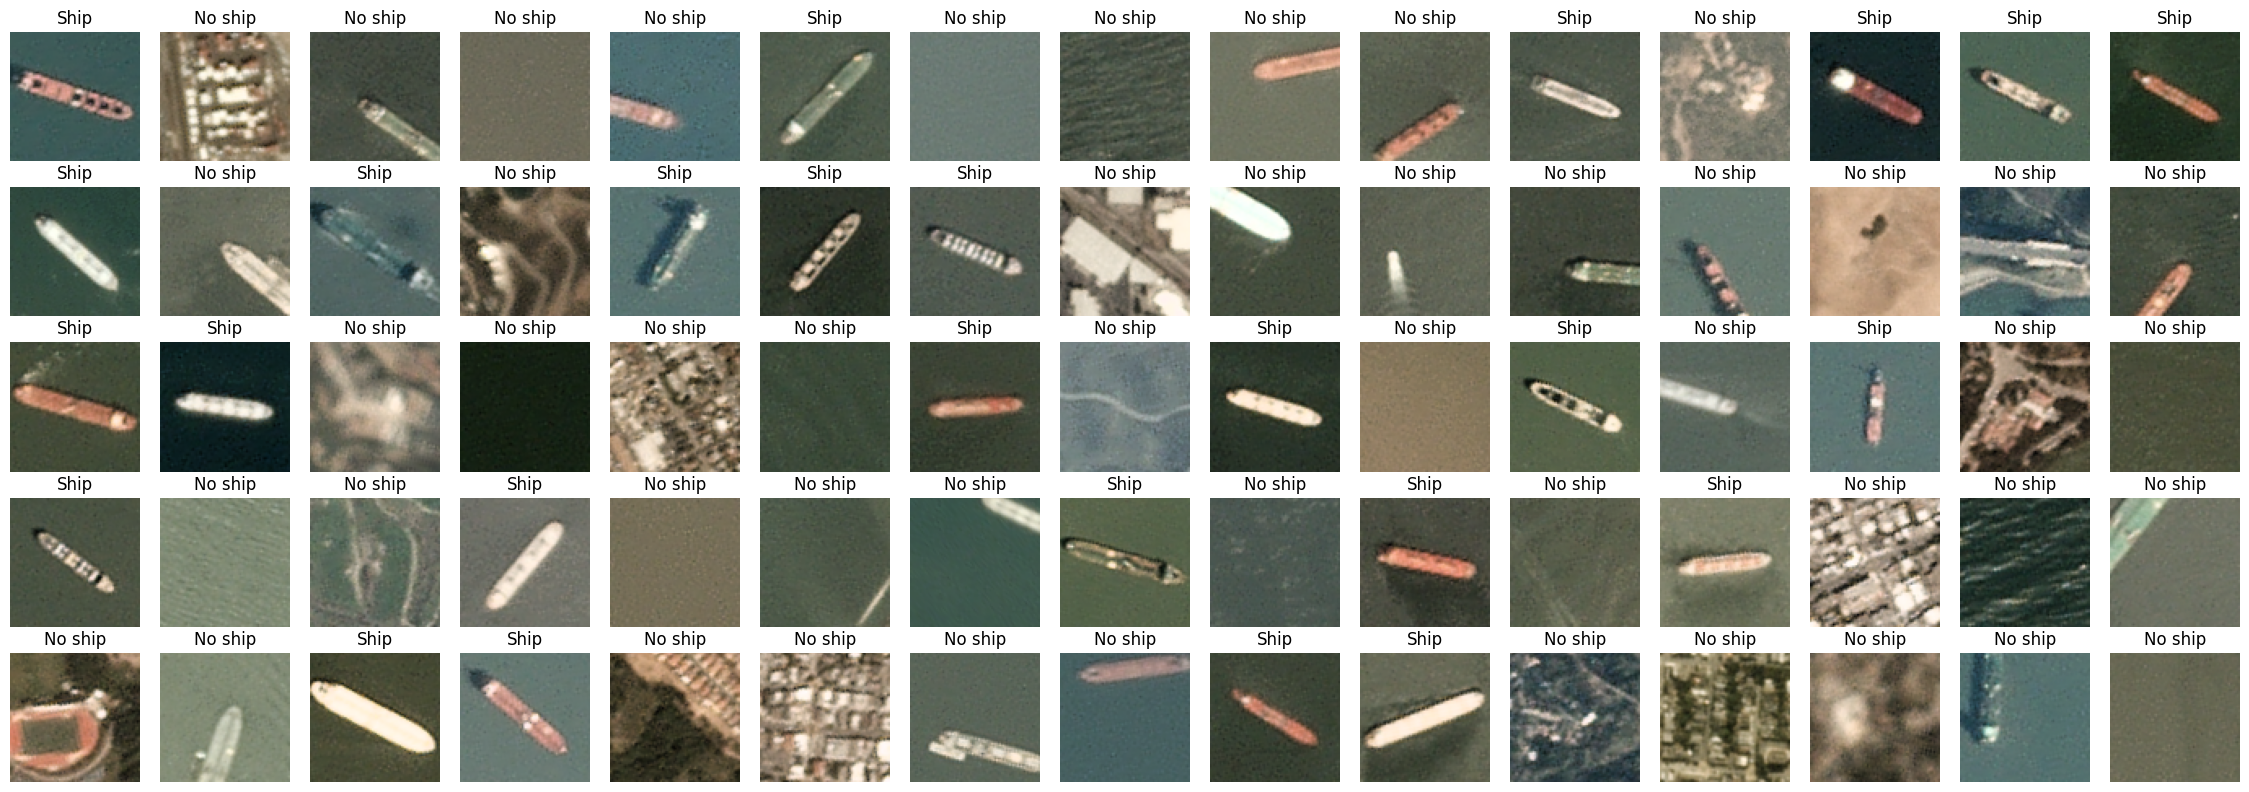

In [ ]:
def plotImageGrid(
    dataframe: pd.DataFrame, 
    shape: tuple[int, int], 
    figsize: tuple[int, int], 
    labels: dict):
    
    rows, cols = shape
    fig, axs = plt.subplots(*shape)
    fig.set_size_inches(*figsize)
    idx = 0
    
    randomIndices = np.random.choice(np.arange(len(dataframe)), (rows*cols,), replace=False)
    for r in range(rows):
        for c in range(cols):
            imageIdx = randomIndices[idx]
            axs[r,c].imshow(dataframe['data'][imageIdx])
            axs[r,c].set_title(labels[dataframe['labels'][imageIdx]])
            axs[r,c].set_axis_off()
            idx += 1
    
    plt.subplots_adjust(
        left=0,
        bottom=0,
        right=1,
        top=1,
        hspace=0.2,
        wspace=0
    )
    plt.show()

r, c = 5, 15
shape = (r, c)
figsize = (c*1.5, r*1.5)

labels = {
    0: 'No ship',
    1: 'Ship'
}

plotImageGrid(df, shape=shape, figsize=figsize, labels=labels)

In [ ]:
# TODO: Generate embeddings tomorrow
gridIndices = np.mgrid[0:80, 0:80]
print(gridIndices.shape)
print(gridIndices)
B = 10_000
D = 6400

gridIndices[0, :, :] = np.sin(gridIndices[0, :, :])



(2, 80, 80)
[[[ 0  0  0 ...  0  0  0]
  [ 1  1  1 ...  1  1  1]
  [ 2  2  2 ...  2  2  2]
  ...
  [77 77 77 ... 77 77 77]
  [78 78 78 ... 78 78 78]
  [79 79 79 ... 79 79 79]]

 [[ 0  1  2 ... 77 78 79]
  [ 0  1  2 ... 77 78 79]
  [ 0  1  2 ... 77 78 79]
  ...
  [ 0  1  2 ... 77 78 79]
  [ 0  1  2 ... 77 78 79]
  [ 0  1  2 ... 77 78 79]]]
